In [2]:
import keras
from keras.models import load_model, model_from_json

Using TensorFlow backend.
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/avanti/anacon

In [10]:
import tensorflow as tf

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tf.contrib.distributions.Multinomial(total_count=counts_per_example,
                                                logits=logits)
    return -tf.reduce_sum(dist.log_prob(true_counts)) / tf.to_float(tf.shape(true_counts)[0])


class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    keras_model = load_model("model.h5")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.cast` instead.


In [11]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq (InputLayer)                (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 64)     6464        seq[0][0]                        
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1000, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1000, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [17]:
def get_out_tensor(inp_tensor, layer_to_copy, param_overrides={}):
    new_config = dict(layer_to_copy.get_config().items())
    for param_name in param_overrides:
        assert param_name in new_config
        new_config[param_name] = param_overrides[param_name]
    new_layer = layer_to_copy.__class__.from_config(new_config)
    adjusted_input_shape = list(layer_to_copy.input_shape)
    assert len(adjusted_input_shape)==3
    adjusted_input_shape[1] = None #flexible input len for convs
    adjusted_input_shape = tuple(adjusted_input_shape)
    new_layer.build(adjusted_input_shape)
    new_layer.set_weights(layer_to_copy.get_weights())
    out_tensor = new_layer(inp_tensor)
    return out_tensor

In [25]:
inp_tensor = keras.layers.Input((None,4))
conv1_out = get_out_tensor(inp_tensor=inp_tensor,
                           layer_to_copy=keras_model.layers[1],
                           param_overrides={'padding': 'same'})
conv2_out = get_out_tensor(inp_tensor=conv1_out,
                           layer_to_copy=keras_model.layers[2],
                           param_overrides={'padding': 'same'})
add1_out = keras.layers.Add()([conv1_out, conv2_out])
conv3_out =  get_out_tensor(inp_tensor=add1_out,
                            layer_to_copy=keras_model.layers[4],
                            param_overrides={'padding': 'same'})
add2_out = keras.layers.Add()([add1_out, conv3_out])
conv4_out =  get_out_tensor(inp_tensor=add2_out,
                            layer_to_copy=keras_model.layers[6],
                            param_overrides={'padding': 'same'})

conv1_gap = keras.layers.GlobalAveragePooling1D()(conv1_out)
conv2_gap = keras.layers.GlobalAveragePooling1D()(conv2_out)
conv3_gap = keras.layers.GlobalAveragePooling1D()(conv3_out)
conv4_gap = keras.layers.GlobalAveragePooling1D()(conv4_out)

concat = keras.layers.Concatenate(axis=-1)([conv1_gap, conv2_gap, conv3_gap, conv4_gap])
embedding_model = keras.models.Model(inputs=inp_tensor, outputs=concat)

In [34]:
embedding_model.save("embedding_model.h5")

In [30]:
import numpy as np
embedding_model.predict(np.random.random((10, 41, 4))).shape

(10, 256)

In [31]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     6464        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_5 (Add)                     (None, None, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [32]:
import numpy as np
import h5py

f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
              +",FALSE,1/deeplift.imp_score.h5", "r")
#f = h5py.File("/users/avanti/deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [33]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

/mnt/lab_data2/avanti/tfmodisco
commit 20e04f852f6d325f58b2fec20795a38070b879ab (HEAD -> filterembed, origin/filterembed)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Thu May 7 15:38:54 2020 -0700

    slightly nicer nb with scores summed across tasks
/mnt/lab_data2/avanti/tfmodisco_bio_experiments/bpnet/trial1
MEMORY 5.305044992
On task Nanog_profile_wn
Computing windowed sums on original
Generating null dist
peak(mu)= 0.00754788601747714
Computing threshold
Thresholds from null dist were -0.026598811149597168  and  0.2509317398071289
Passing windows frac was 0.04676685078463518 , which is above  0.03 ; adjusting
Final raw thresholds are -0.3184376752376554  and  0.3184376752376554
Final transformed thresholds are -0.9699999852203116  and  0.9699999852203116


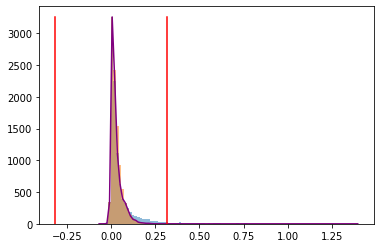

Got 98300 coords
After resolving overlaps, got 98300 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9698999852203116
MEMORY 6.124609536
98300 identified in total
1 activity patterns with support >= 2000 out of 3 possible patterns
Metacluster sizes:  [98297]
Idx to activities:  {0: '1'}
MEMORY 6.1251584
On metacluster 0
Metacluster size 98297 limited to 50000
Relevant tasks:  ('Nanog_profile_wn',)
Relevant signs:  (1,)


/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 50000
(Round 1) Computing coarse affmat
MEMORY 6.126829568
Beginning embedding computation
Finished embedding computation in 21.36 s
Starting affinity matrix computations
Normalization computed in 0.25 s
Cosine similarity mat computed in 17.95 s
Normalization computed in 0.22 s
Cosine similarity mat computed in 17.96 s
Finished affinity matrix computations in 55.85 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 16.154394624
Computed nearest neighbors in 196.08 s
MEMORY 16.97263616
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 16.97263616
Launching nearest neighbors affmat calculation job
MEMORY 17.142984704
Parallel runs completed
MEMORY 17.575170048
Job completed in: 418.6 s
MEMORY 37.106323456
Launching nearest neighbors affmat calculation job
MEMORY 37.10025728
Parallel runs completed
MEMORY 37.191921664
Job completed in: 411.38 s
MEMORY 56.722948096
(Round 1) Computed affinity mat

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.8340778175111937


 42%|████▏     | 21/50 [01:45<02:08,  4.43s/it]

Quality: 0.8343152834851778


 66%|██████▌   | 33/50 [02:38<01:12,  4.27s/it]

Quality: 0.8345608891128656


100%|██████████| 50/50 [04:01<00:00,  4.83s/it]

Got 35 clusters after round 1
Counts:
{20: 74, 7: 498, 8: 476, 1: 1001, 2: 766, 13: 291, 17: 153, 14: 286, 9: 461, 30: 25, 19: 87, 21: 62, 5: 642, 0: 1288, 4: 714, 29: 32, 6: 635, 11: 409, 10: 413, 27: 39, 3: 740, 12: 299, 15: 232, 16: 223, 32: 12, 18: 106, 28: 35, 22: 50, 26: 40, 33: 10, 31: 20, 25: 42, 34: 9, 23: 47, 24: 46}
MEMORY 7.4457088
(Round 1) Aggregating seqlets in each cluster
MEMORY 7.4457088
Aggregating for cluster 0 with 1288 seqlets
MEMORY 7.4457088


Trimmed 28 out of 1288
Aggregating for cluster 1 with 1001 seqlets
MEMORY 7.45222144
Trimmed 43 out of 1001
Aggregating for cluster 2 with 766 seqlets
MEMORY 7.453052928
Trimmed 38 out of 766
Aggregating for cluster 3 with 740 seqlets
MEMORY 7.453990912
Trimmed 82 out of 740
Aggregating for cluster 4 with 714 seqlets
MEMORY 7.456382976
Trimmed 101 out of 714
Aggregating for cluster 5 with 642 seqlets
MEMORY 7.456768
Trimmed 17 out of 642
Aggregating for cluster 6 with 635 seqlets
MEMORY 7.458557952
Trimmed 27 out of 635
Aggregating for cluster 7 with 498 seqlets
MEMORY 7.45908224
Trimmed 34 out of 498
Aggregating for cluster 8 with 476 seqlets
MEMORY 7.459848192
Trimmed 45 out of 476
Skipped 1 seqlets
Aggregating for cluster 9 with 461 seqlets
MEMORY 7.461289984
Trimmed 107 out of 461
Skipped 1 seqlets
Aggregating for cluster 10 with 413 seqlets
MEMORY 7.462125568
Trimmed 22 out of 413
Aggregating for cluster 11 with 409 seqlets
MEMORY 7.463006208
Trimmed 88 out of 409
Aggregating for 

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.8128469656057034


  2%|▏         | 1/50 [00:04<03:43,  4.57s/it]

Quality: 0.8132417320247777


  6%|▌         | 3/50 [00:15<03:59,  5.09s/it]

Quality: 0.8142977742217368


100%|██████████| 50/50 [03:58<00:00,  4.76s/it]

Got 39 clusters after round 2
Counts:
{17: 108, 0: 1139, 3: 889, 9: 229, 5: 585, 2: 919, 22: 75, 20: 83, 6: 443, 28: 47, 7: 399, 4: 752, 16: 108, 36: 24, 25: 64, 1: 1116, 10: 228, 8: 252, 34: 31, 26: 52, 32: 33, 13: 180, 31: 33, 21: 78, 29: 45, 23: 74, 12: 201, 19: 87, 11: 202, 24: 70, 37: 18, 27: 50, 15: 132, 35: 24, 30: 38, 38: 11, 14: 178, 18: 108, 33: 32}
MEMORY 6.707331072
(Round 2) Aggregating seqlets in each cluster
MEMORY 6.707068928
Aggregating for cluster 0 with 1139 seqlets
MEMORY 6.707068928


Trimmed 10 out of 1139
Removed 1 duplicate seqlets
Aggregating for cluster 1 with 1116 seqlets
MEMORY 6.714068992
Trimmed 21 out of 1116
Aggregating for cluster 2 with 919 seqlets
MEMORY 6.714785792
Trimmed 95 out of 919
Aggregating for cluster 3 with 889 seqlets
MEMORY 6.715879424
Trimmed 23 out of 889
Aggregating for cluster 4 with 752 seqlets
MEMORY 6.718603264
Trimmed 61 out of 752
Skipped 1 seqlets
Aggregating for cluster 5 with 585 seqlets
MEMORY 6.720708608
Trimmed 12 out of 585
Aggregating for cluster 6 with 443 seqlets
MEMORY 6.720708608
Trimmed 23 out of 443
Aggregating for cluster 7 with 399 seqlets
MEMORY 6.720753664
Trimmed 12 out of 399
Aggregating for cluster 8 with 252 seqlets
MEMORY 6.722535424
Trimmed 9 out of 252
Removed 88 duplicate seqlets
Aggregating for cluster 9 with 229 seqlets
MEMORY 6.722592768
Trimmed 18 out of 229
Removed 64 duplicate seqlets
Aggregating for cluster 10 with 228 seqlets
MEMORY 6.722592768
Trimmed 24 out of 228
Aggregating for cluster 11 with

After 1 runs, maximum modularity is Q = 0.00266508
After 3 runs, maximum modularity is Q = 0.00268032
Louvain completed 23 runs in 4.317308187484741 seconds
Similarity is 0.9288704; is_dissimilar is False
Inspecting for spurious merging
Wrote graph to binary file in 0.00532221794128418 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0149975
After 2 runs, maximum modularity is Q = 0.0177069
Louvain completed 22 runs in 4.245438098907471 seconds
Similarity is 0.72544485; is_dissimilar is True
Inspecting for spurious merging
Wrote graph to binary file in 0.004053831100463867 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.02465
Louvain completed 21 runs in 3.791588068008423 seconds
Similarity is 0.72737885; is_dissimilar is True
Inspecting for spurious merging
Wrote graph to binary file in 0.012972116470336914 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0086113

Similarity is 0.80138564; is_dissimilar is False
Inspecting for spurious merging
Wrote graph to binary file in 0.004891157150268555 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0330855
Louvain completed 21 runs in 4.412413835525513 seconds
Similarity is 0.724958; is_dissimilar is True
Got 2 subclusters
Merging on 45 clusters
MEMORY 6.726569984
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 3 & 5 with prob 0.0013927185596589707 and sim 0.9869247353750606
Collapsing 8 & 16 with prob 0.005038473909524972 and sim 0.9431000634165401
Collapsing 40 & 43 with prob 0.0025833932239464146 and sim 0.934942281780029
Collapsing 1 & 28 with prob 9.644349327294803e-05 and sim 0.9212578745812378
Collapsing 3 & 7 with prob 0.00029457009607627624 and sim 0.9173979650022104
Collapsing 5 & 7 with prob 1.446805138489272e-05 and sim 0.9120550174752964
Collapsing 8 & 18 with prob 0.0009037387299231419 

In [37]:
#print modisco commit hash
%cd /users/avanti/tfmodisco
!git log -n 1
%cd /users/avanti/tfmodisco_bio_experiments/bpnet/trial1

from importlib import reload

%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

%matplotlib inline

workflow = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
    sliding_window_size=21,
    flank_size=10,
    target_seqlet_fdr=0.01,
    min_passing_windows_frac=0.03,
    max_passing_windows_frac=0.03,
    min_metacluster_size=2000,
    min_metacluster_size_frac=0.02,
    max_seqlets_per_metacluster=50000,
    seqlets_to_patterns_factory=
      modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
        #                meme_command="/software/meme/5.0.1/bin/meme",
        #                base_outdir="meme_out",            
        #                max_num_seqlets_to_use=10000,
        #                nmotifs=20, n_jobs=4),
        use_louvain=False,
        trim_to_window_size=30,
        initial_flank_to_add=10,
        embedder_factory=(modisco.seqlet_embedding
                          .onehot_model_output.KerasModelOutputEmbedder
                          .get_factory(model_h5="embedding_model.h5")),
        n_cores=10,
        final_min_cluster_size=30
    )
)

results = workflow(
    task_names=["Nanog_profile_wn"],
    contrib_scores={'Nanog_profile_wn': nanog_profile_wn_contribs},
    hypothetical_contribs={'Nanog_profile_wn': nanog_profile_wn_hypimp},
    one_hot=onehot_seq)

In [38]:
import h5py
import modisco.util
reload(modisco.util)
import os

file_path = "commit20e04f_nomemeinit_4layerembedding_results.hdf5"
if (os.path.exists(file_path)):
    os.remove(file_path)
grp = h5py.File(file_path, "w")
results.save_hdf5(grp)
grp.close()

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 2928
Task 0 hypothetical scores:


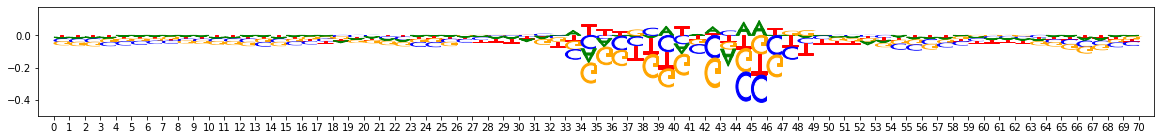

Task 0 actual importance scores:


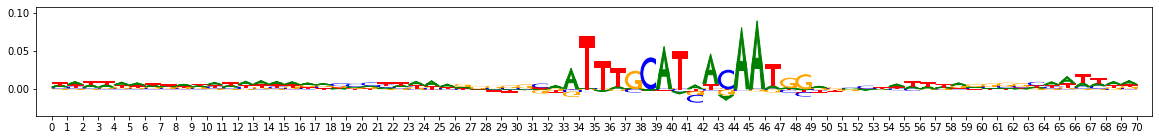

onehot, fwd and rev:


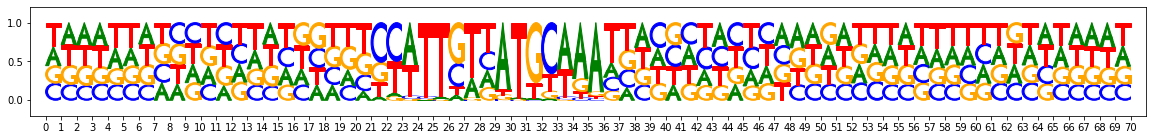

metacluster_0 pattern_1
total seqlets: 1165
Task 0 hypothetical scores:


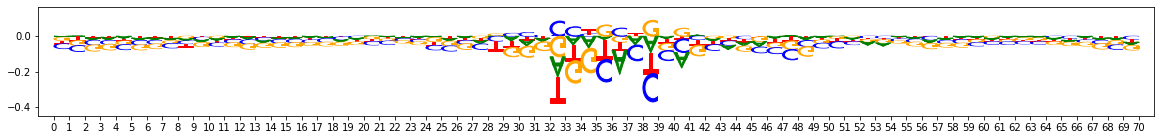

Task 0 actual importance scores:


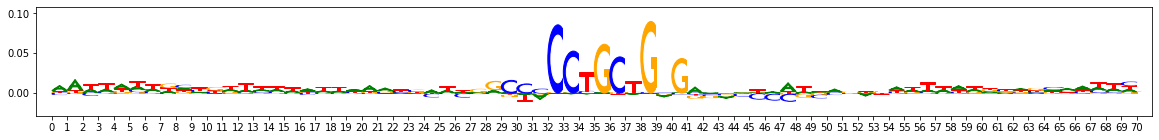

onehot, fwd and rev:


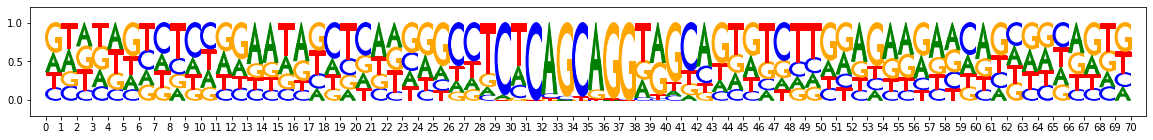

metacluster_0 pattern_2
total seqlets: 852
Task 0 hypothetical scores:


Task 0 actual importance scores:


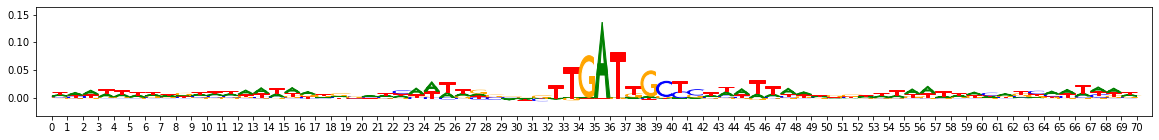

onehot, fwd and rev:


metacluster_0 pattern_3
total seqlets: 697
Task 0 hypothetical scores:


Task 0 actual importance scores:


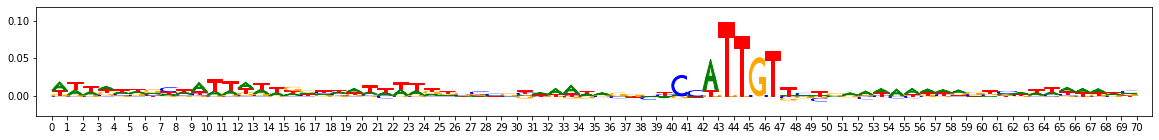

onehot, fwd and rev:


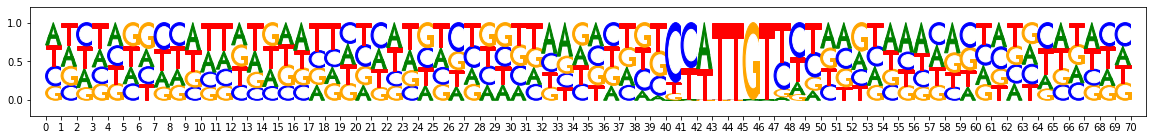

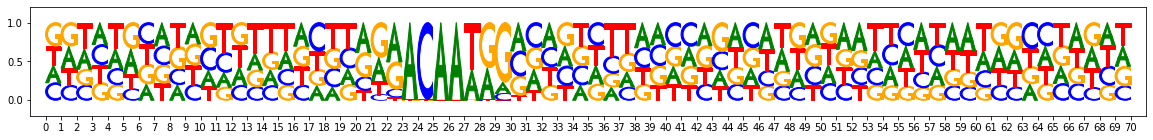

metacluster_0 pattern_4
total seqlets: 612
Task 0 hypothetical scores:


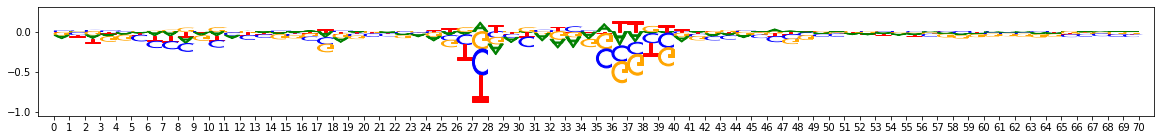

Task 0 actual importance scores:


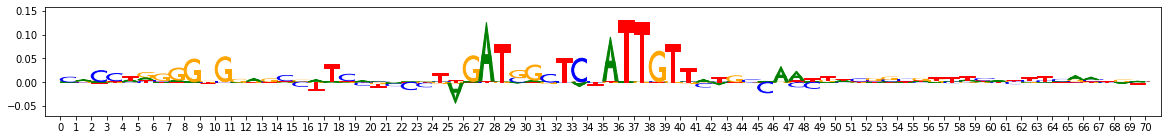

onehot, fwd and rev:


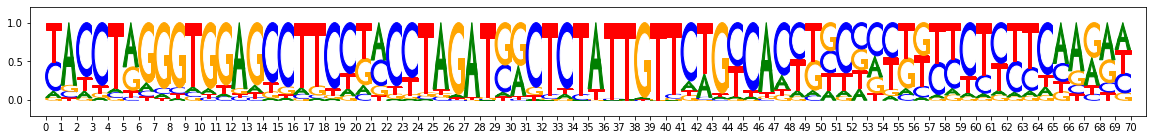

metacluster_0 pattern_5
total seqlets: 424
Task 0 hypothetical scores:


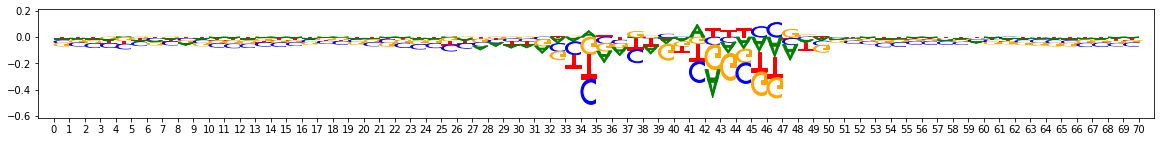

Task 0 actual importance scores:


onehot, fwd and rev:


metacluster_0 pattern_6
total seqlets: 211
Task 0 hypothetical scores:


Task 0 actual importance scores:


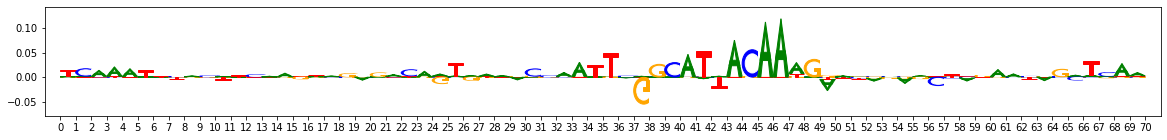

onehot, fwd and rev:


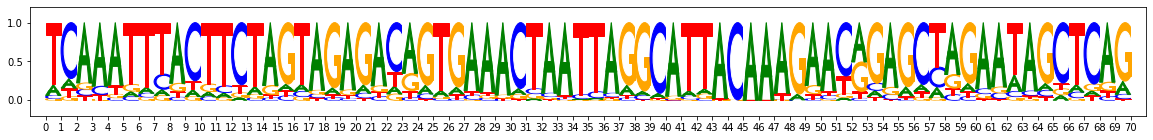

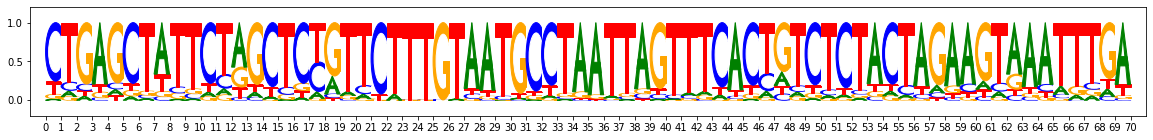

metacluster_0 pattern_7
total seqlets: 155
Task 0 hypothetical scores:


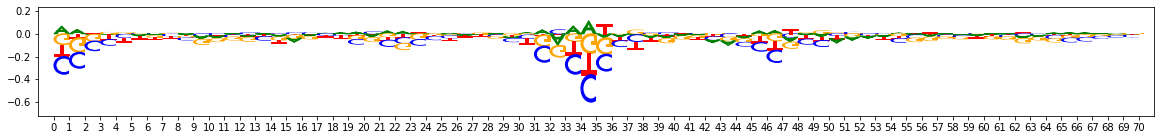

Task 0 actual importance scores:


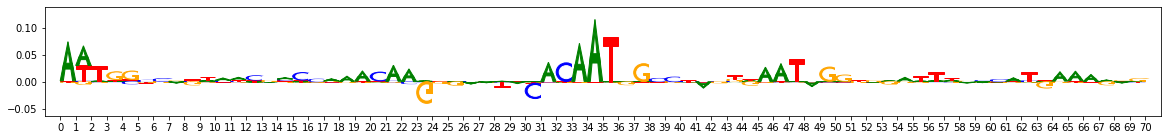

onehot, fwd and rev:


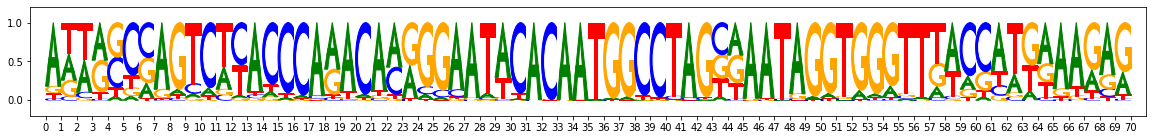

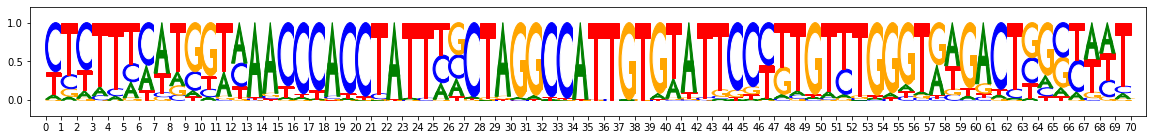

metacluster_0 pattern_8
total seqlets: 149
Task 0 hypothetical scores:


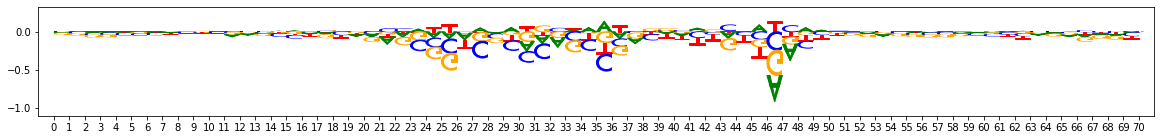

Task 0 actual importance scores:


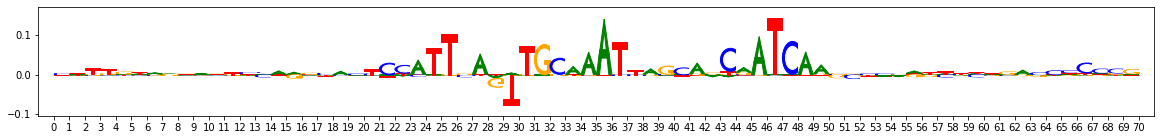

onehot, fwd and rev:


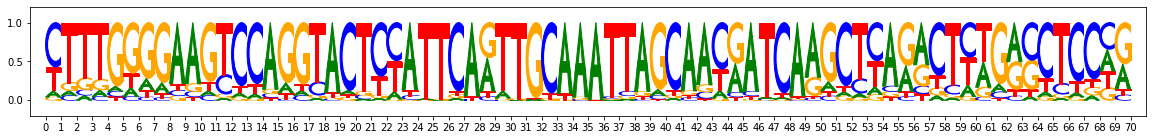

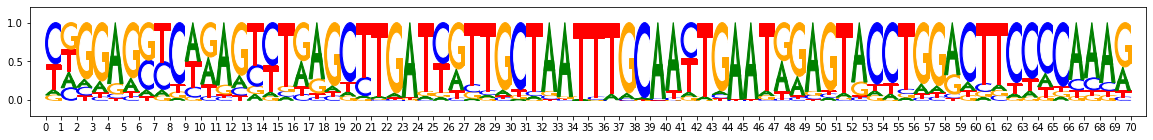

metacluster_0 pattern_9
total seqlets: 129
Task 0 hypothetical scores:


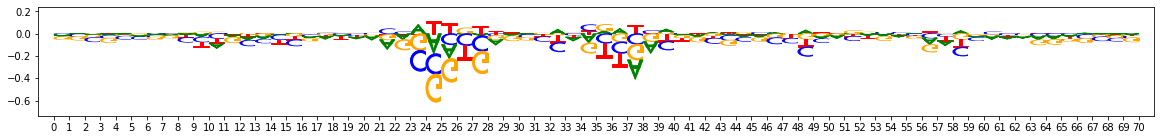

Task 0 actual importance scores:


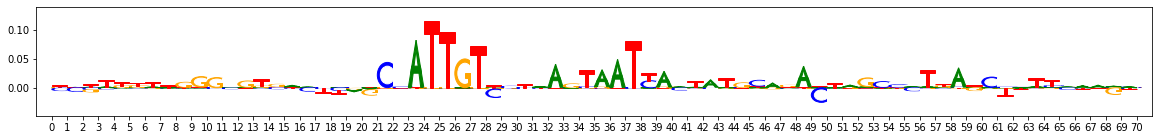

onehot, fwd and rev:


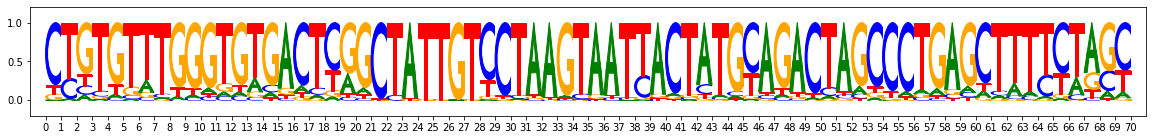

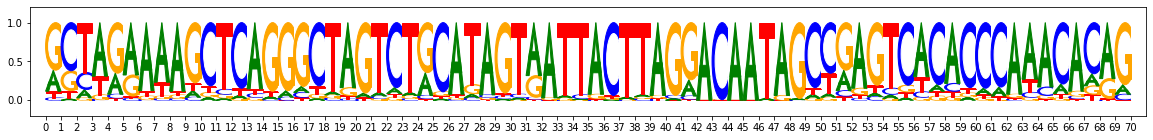

metacluster_0 pattern_10
total seqlets: 97
Task 0 hypothetical scores:


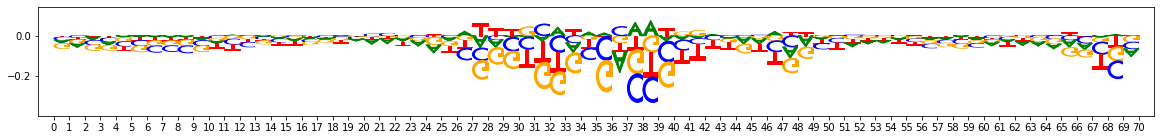

Task 0 actual importance scores:


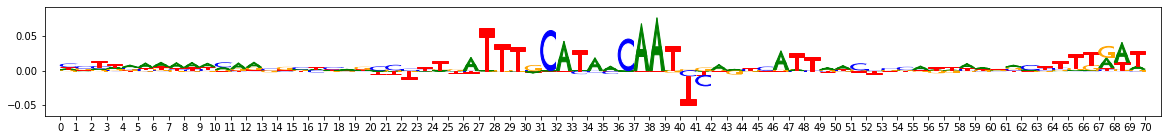

onehot, fwd and rev:


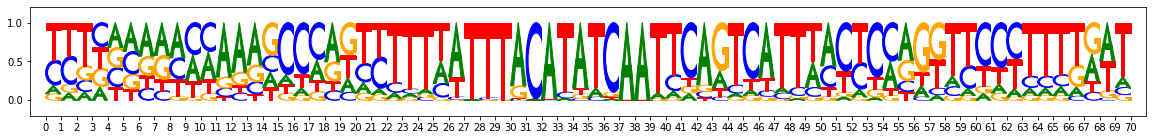

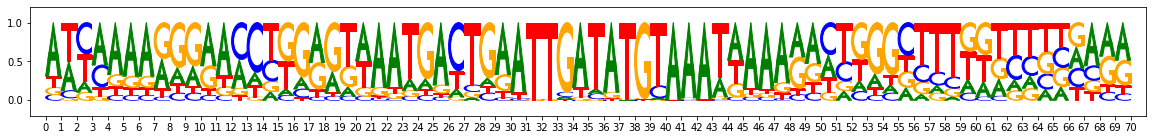

metacluster_0 pattern_11
total seqlets: 77
Task 0 hypothetical scores:


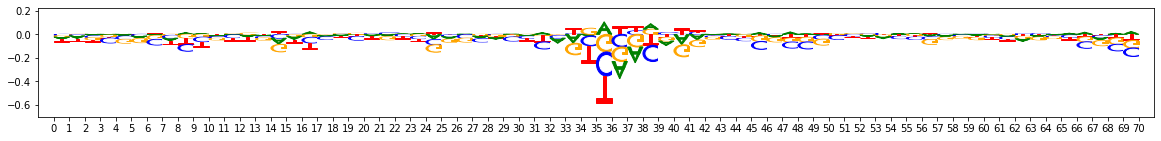

Task 0 actual importance scores:


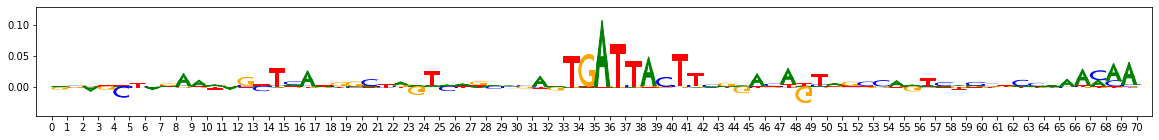

onehot, fwd and rev:


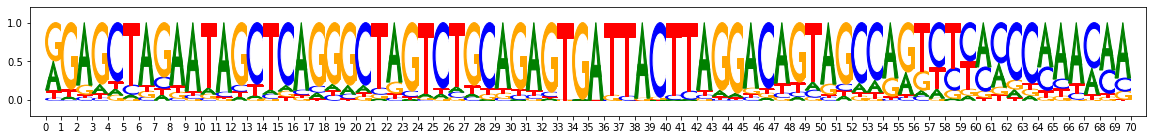

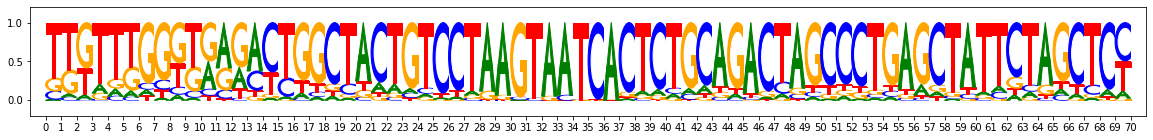

metacluster_0 pattern_12
total seqlets: 117
Task 0 hypothetical scores:


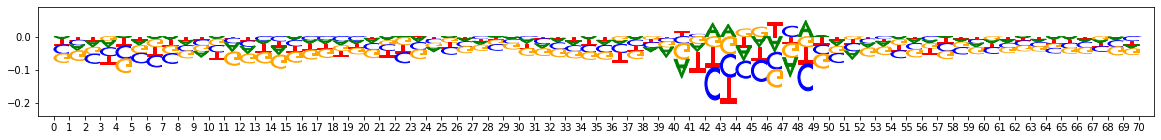

Task 0 actual importance scores:


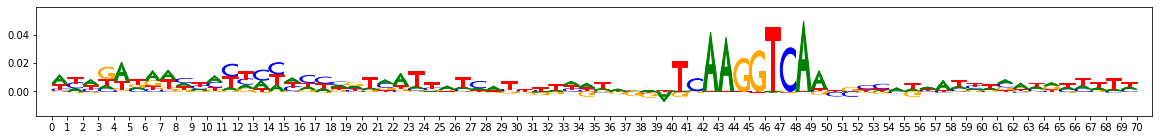

onehot, fwd and rev:


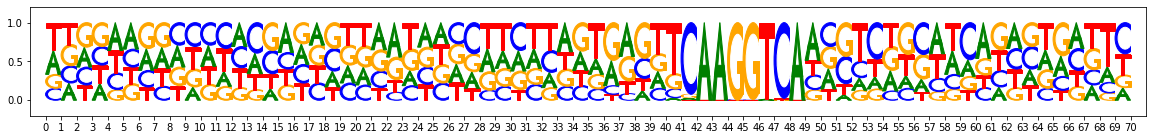

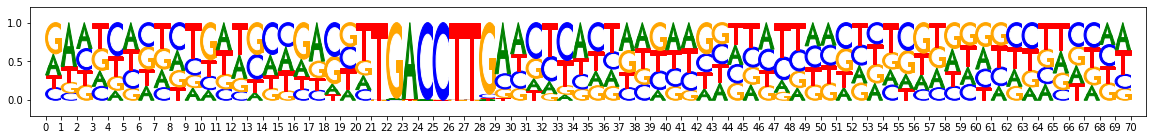

metacluster_0 pattern_13
total seqlets: 92
Task 0 hypothetical scores:


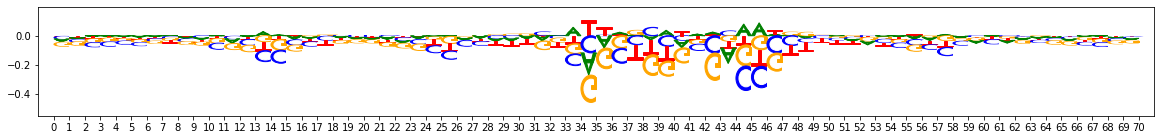

Task 0 actual importance scores:


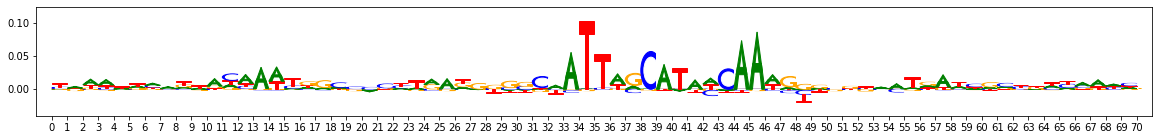

onehot, fwd and rev:


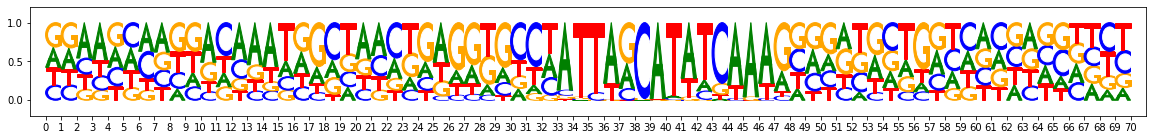

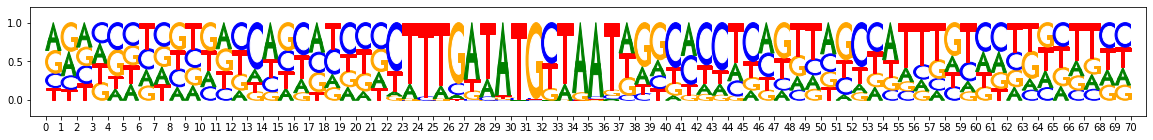

metacluster_0 pattern_14
total seqlets: 81
Task 0 hypothetical scores:


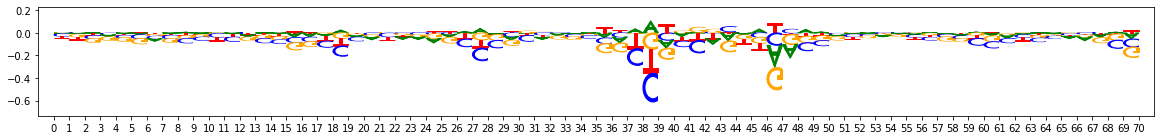

Task 0 actual importance scores:


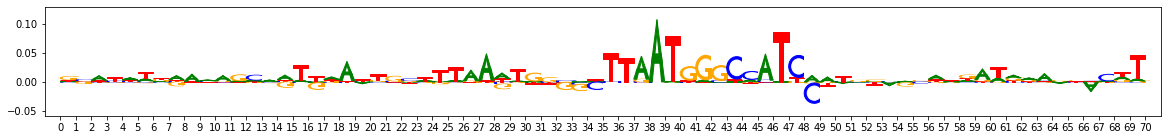

onehot, fwd and rev:


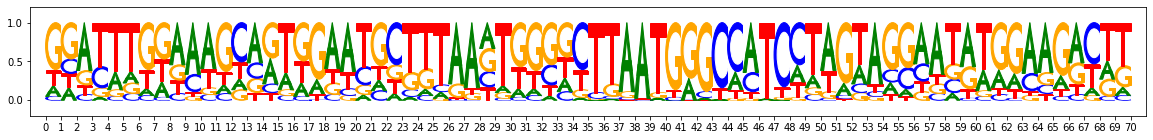

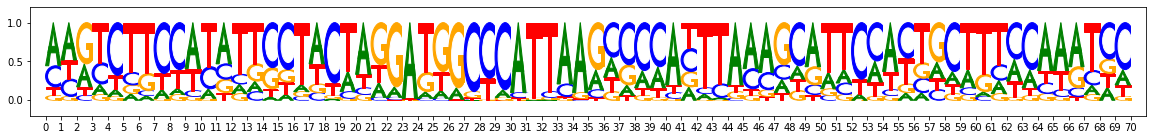

metacluster_0 pattern_15
total seqlets: 66
Task 0 hypothetical scores:


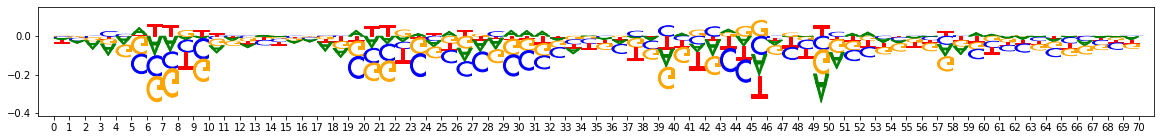

Task 0 actual importance scores:


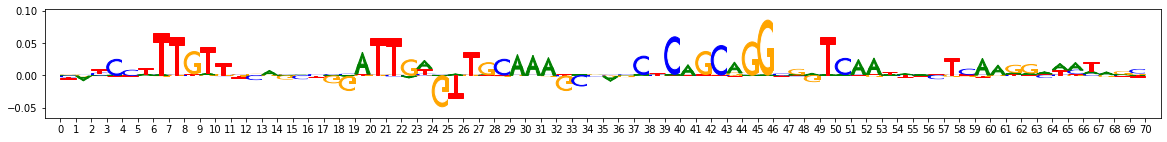

onehot, fwd and rev:


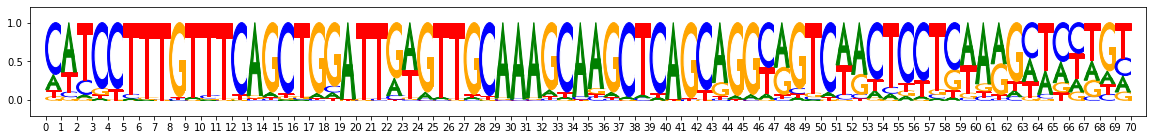

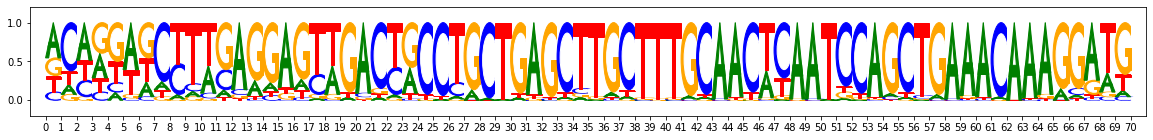

metacluster_0 pattern_16
total seqlets: 65
Task 0 hypothetical scores:


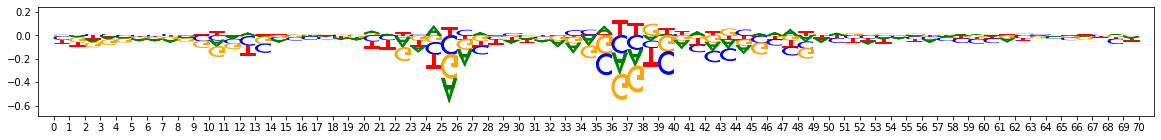

Task 0 actual importance scores:


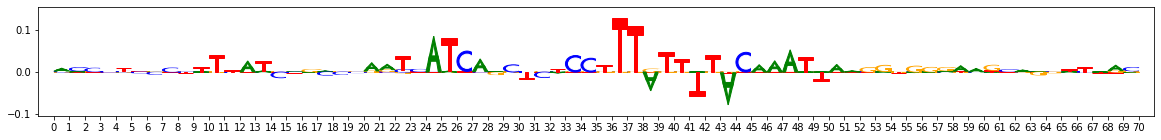

onehot, fwd and rev:


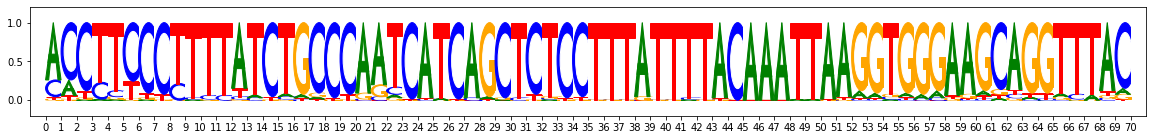

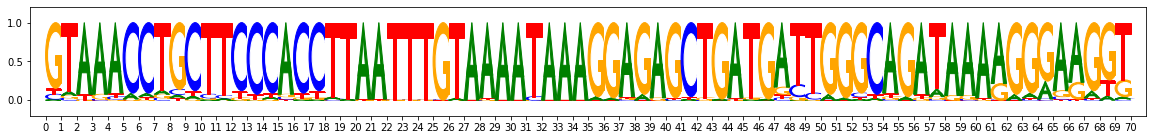

metacluster_0 pattern_17
total seqlets: 57
Task 0 hypothetical scores:


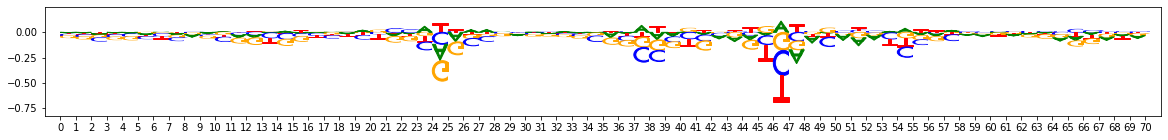

Task 0 actual importance scores:


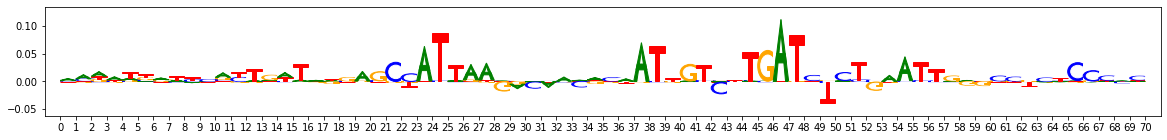

onehot, fwd and rev:


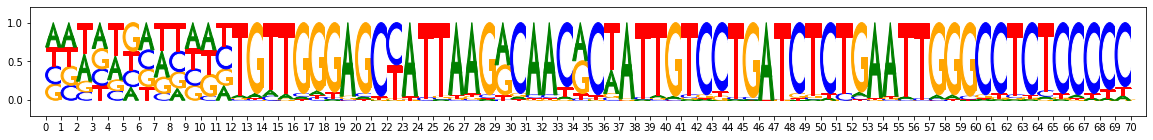

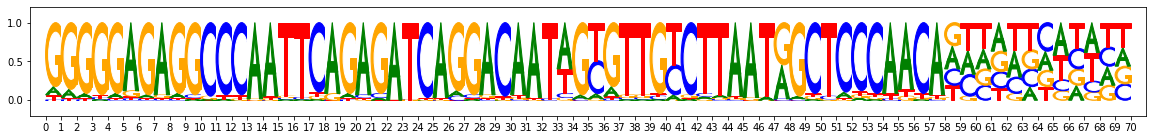

metacluster_0 pattern_18
total seqlets: 61
Task 0 hypothetical scores:


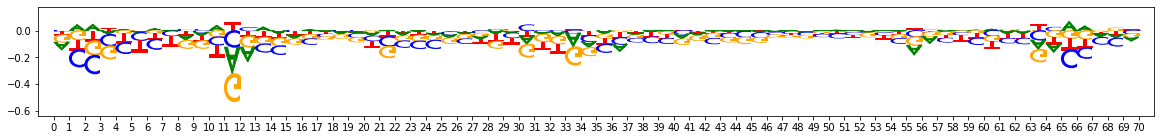

Task 0 actual importance scores:


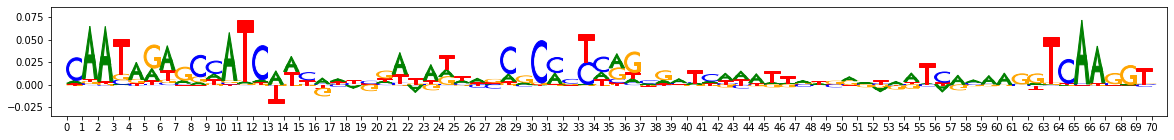

onehot, fwd and rev:


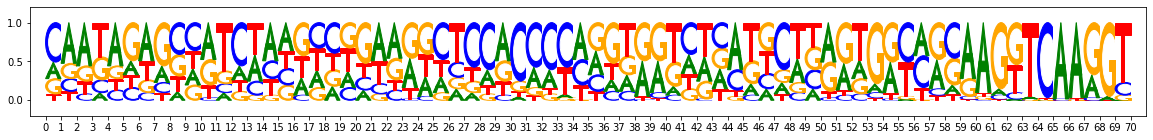

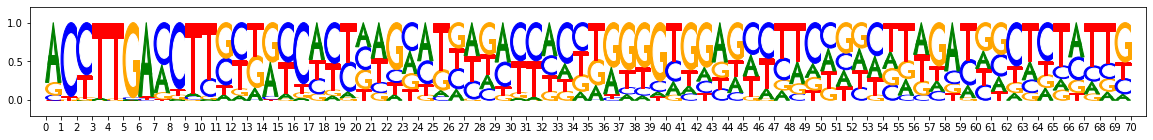

metacluster_0 pattern_19
total seqlets: 35
Task 0 hypothetical scores:


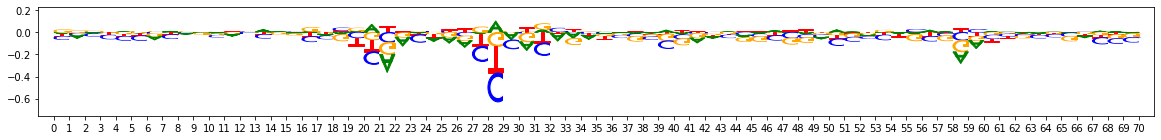

Task 0 actual importance scores:


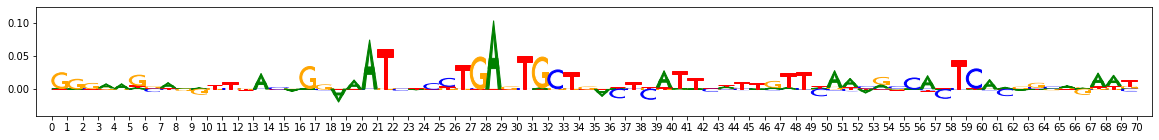

onehot, fwd and rev:


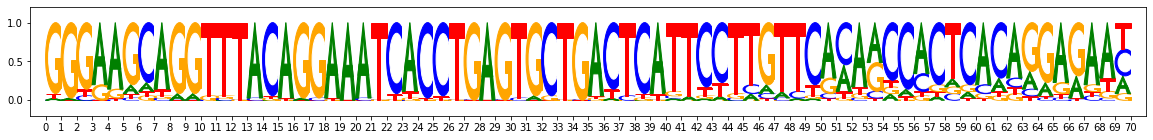

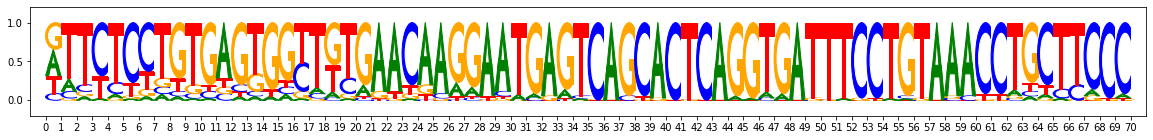

metacluster_0 pattern_20
total seqlets: 49
Task 0 hypothetical scores:


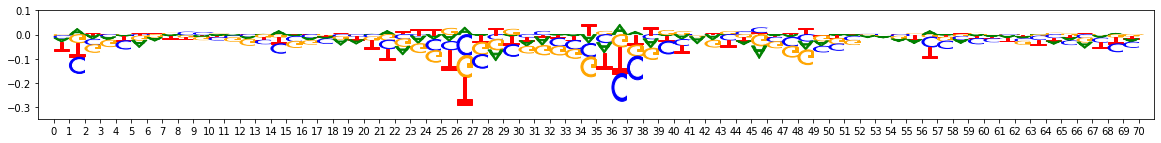

Task 0 actual importance scores:


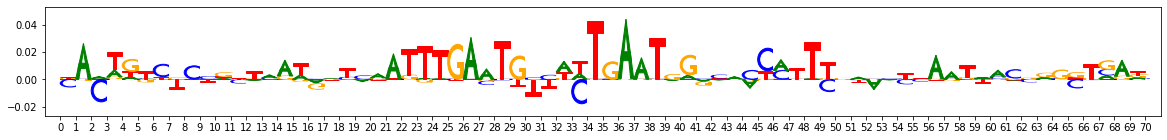

onehot, fwd and rev:


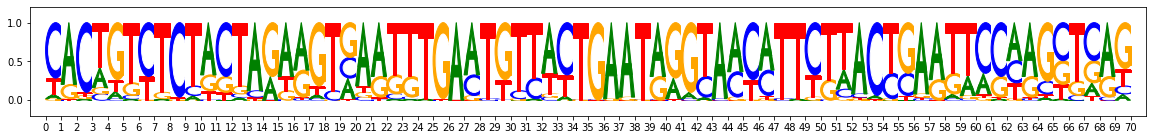

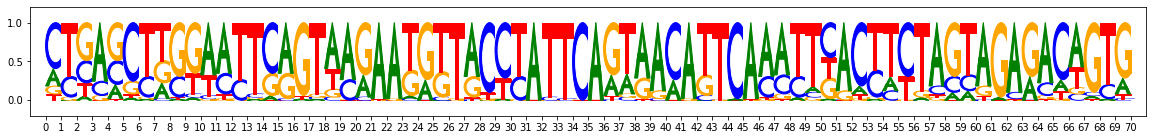

metacluster_0 pattern_21
total seqlets: 39
Task 0 hypothetical scores:


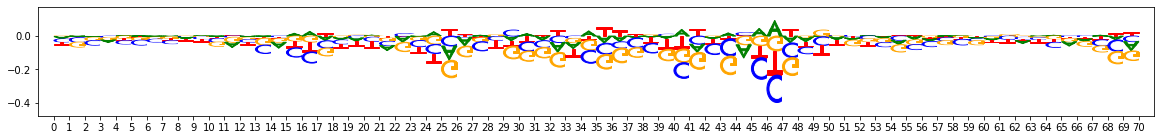

Task 0 actual importance scores:


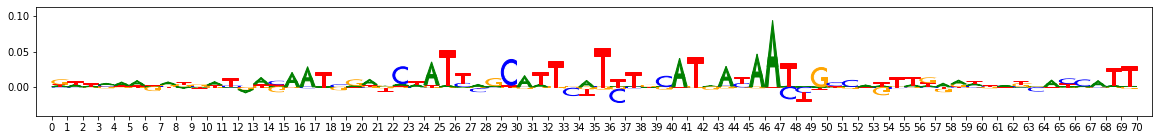

onehot, fwd and rev:


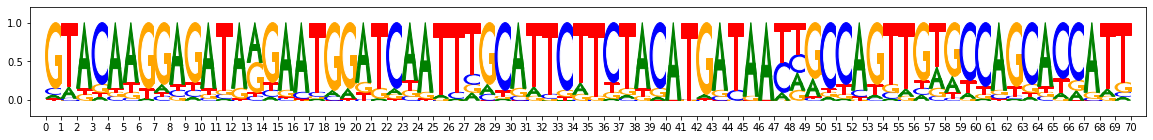

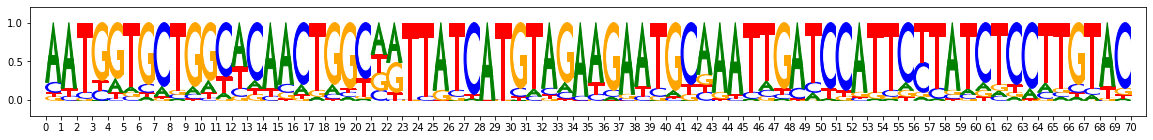

metacluster_0 pattern_22
total seqlets: 33
Task 0 hypothetical scores:


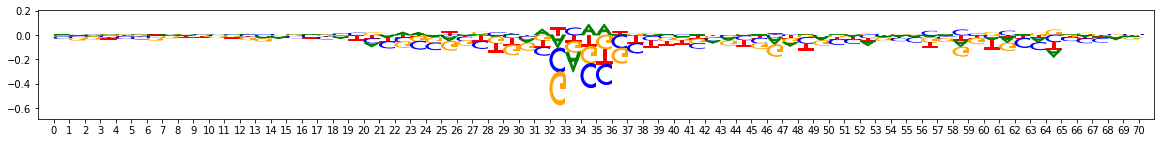

Task 0 actual importance scores:


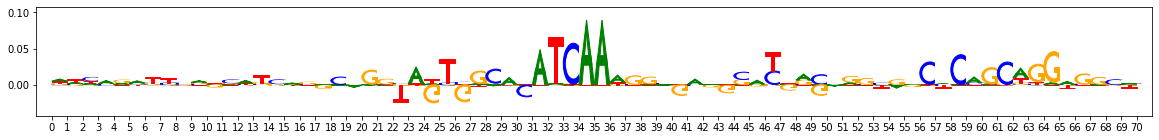

onehot, fwd and rev:


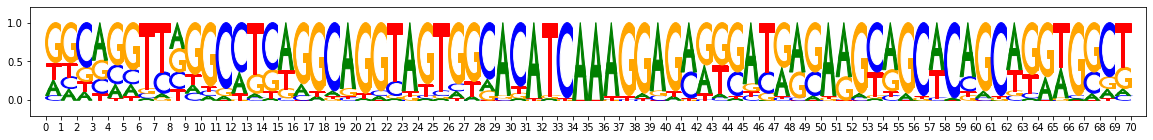

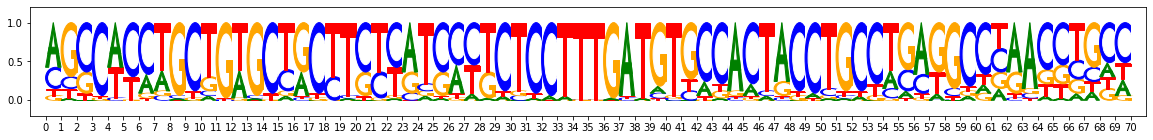

metacluster_0 pattern_23
total seqlets: 36
Task 0 hypothetical scores:


Task 0 actual importance scores:


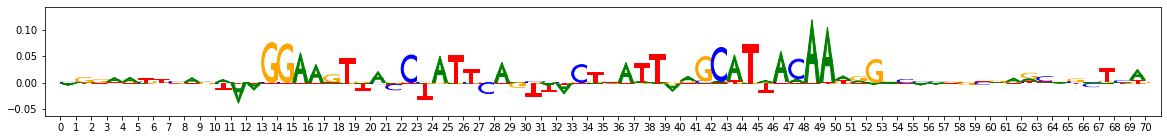

onehot, fwd and rev:


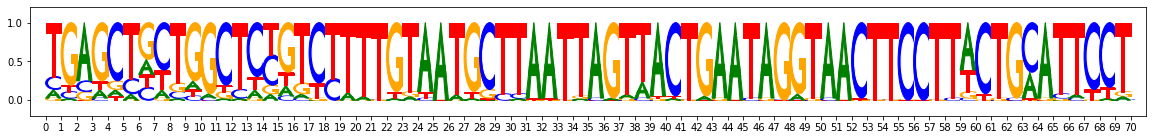

In [39]:
from modisco.visualization import viz_sequence
%matplotlib inline

hdf5_results = h5py.File(file_path,"r")

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["Nanog_profile_wn_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["Nanog_profile_wn_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(np.array(pattern["sequence"]["fwd"])) 
        viz_sequence.plot_weights(np.array(pattern["sequence"]["rev"])) 
        
hdf5_results.close()